In [1]:
import os
import gc
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import nltk
import string
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import mlflow
import mlflow.sklearn
import mlflow.keras
from mlflow.models.signature import infer_signature
import re
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc as auc_score_func
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, accuracy_score, average_precision_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy
from spacy.tokens import Doc
from spacy.language import Language
import gensim

import tensorflow as tf
# import tensorflow.keras.backend as K
# tf.compat.v1.disable_v2_behavior()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU")
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_hub as hub
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel, BertConfig
from tqdm import tqdm
from gensim.models import KeyedVectors
import gensim.downloader as api
import fasttext.util
from numba import cuda
from sklearn.model_selection import RandomizedSearchCV
import shap
import pickle
from lime.lime_text import LimeTextExplainer
from collections import defaultdict
# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_data():
    """
    Charge les données de tweets à partir du fichier CSV spécifié et affiche les premières lignes.
    Return:
        pd.DataFrame: DataFrame contenant les données des tweets.
    """
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", names=column_names, encoding='latin1')
    display(df)
    return df

df = load_data()

target         ids                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user  \
0        _TheSpecialOne_   
1          scotthamilton   
2               mattycus   
3                ElleCTF   
4                 Karoli   
...                  ...   
1599995  AmandaMarie1028   
1599996      TheWDBoards   
1599997           bpbabe   
1599998     tinydiamondz   
1599999   RyanTrevMorris   

                                                                                                        text  
0        @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...  
1        is upset that he can't update his Facebook by texting it... and might cry as a result  School to...  
2                  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds  
3                                                            my whole body feels itchy and like its on fire   
4        @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a...  
...                                                                                                      ...  
1599995                                             Just woke up. Having no school is the best feeling ever   
1599996                       TheWDB.com - Very cool to hear old Walt interviews!  â« http://blip.fm/~8bmta  
1599997                                            Are you ready for your MoJo Makeover? Ask me for details   
1599998                                    Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur   
1599999                                       happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H   

[1600000 rows x 6 columns]

## Analyse des données

In [16]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

target    0.0
ids       0.0
date      0.0
flag      0.0
user      0.0
text      0.0
dtype: float64
Nombres de tweets dupliqués :  18534
col = target -> duplicated = 1599998
col = ids -> duplicated = 1685
col = date -> duplicated = 825637
col = flag -> duplicated = 1599999
col = user -> duplicated = 940225
col = text -> duplicated = 18534


0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: text, Length: 1600000, dtype: bool


target           ids
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09

date      flag      user  \
count                        1600000   1600000   1600000   
unique                        774363         1    659775   
top     Mon Jun 15 12:53:14 PDT 2009  NO_QUERY  lost_dog   
freq                              20   1600000       549   

                             text  
count                     1600000  
unique                    1581466  
top     isPlayer Has Died! Sorry   
freq                          210

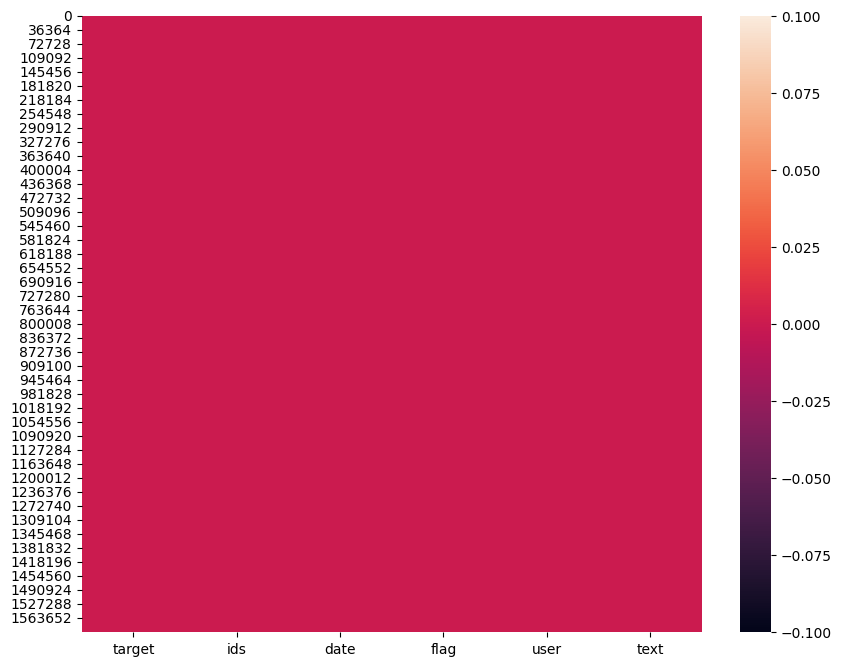

In [4]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Return:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

analyse_data(df)

C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

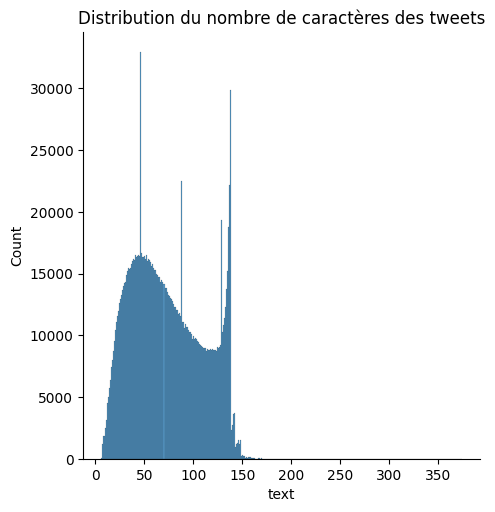

In [18]:
tmp = df.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [19]:
tmp.sort_values(ascending=False)

1295281    374
1484882    369
380539     359
1582941    359
650945     348
          ... 
1071086      6
1229947      6
4233         6
310554       6
1050599      6
Name: text, Length: 1600000, dtype: int64

In [3]:
def drop_columns(df):
    """
    Supprime toutes les colonnes sauf 'target' et 'text'.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    """
    Supprime les tweets en double.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame sans doublons.
    """
    df = df.drop_duplicates(subset="text")
    return df

def filter_tweet(df):
    """
    Filtre et supprime les tweets non informatifs et affiche les premières lignes supprimées.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame filtré.
    """
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df

df = drop_columns(df)
df = drop_text_duplicate(df)
df = filter_tweet(df)

target              text
208        0         @mandayyy
249        0         @mandayyy
398        0     @danadearmond
430        0         @anistorm
1011       0     @citizensheep
1014       0   @GirlsGoneChild
1231       0    @thecoolestout
1421       0   @marlonjenglish
1486       0       @oishiieats
1641       0       @thisisguan
2898       0         @AnotherA
4377       0  @TheBlondeTheory
4508       0      @_EmilyYoung
6058       0     @Tnkdifferent
6419       0   @whiterobisdead
7840       0        @reinmouse
8838       0           @wunmic
9072       0    @theropolitans
9556       0     @whatkilesaid
9599       0     @CHELLETASTIC

Nombre de tweets non informatif supprimés : 2552


In [4]:
def create_sample(df, n_sample):
    """
    Crée un échantillon de tweets positifs et négatifs.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
        n_sample (int): Nombre d'échantillons de chaque sentiment.
    Return:
        pd.DataFrame: DataFrame contenant les échantillons.
    """
    negative_tweets = df[df.iloc[:, 0] == 0]
    negative_tweets = negative_tweets.sample(n = n_sample, random_state=0)
    positive_tweets = df[df.iloc[:, 0] == 4]
    positive_tweets.loc[:,'target'] = positive_tweets['target'].replace({4:1})
    positive_tweets = positive_tweets.sample(n = n_sample, random_state=0)
    df_sample = pd.concat([negative_tweets, positive_tweets], ignore_index=True)
    return df_sample
df_sample = create_sample(df, 750_000)

In [7]:
df_sample.target.value_counts(normalize=True)

0    0.5
1    0.5
Name: target, dtype: float64

### Preprocessing

In [14]:
"""
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
"""

"\nnltk.download('omw-1.4')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('words')\n"

In [5]:
def expand_contractions(text: str) -> str:
    """
    Étend les contractions dans une chaîne de texte.
    Args:
        text (str): Texte d'entrée. 
    Return:
        str: Texte avec contractions étendues.
    """
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    
    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )
    
    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )
    
    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )
    
    ## expand words without '
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs,
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller,
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor,
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major,
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)
    
    return text

In [6]:
class ExpandContractionsComponent:
    """
    Composant spaCy pour étendre les contractions dans un document.
    """
    name = "expand_contractions"

    def __init__(self, nlp: Language):
        self.nlp = nlp

    def __call__(self, doc: Doc) -> Doc:
        text = doc.text
        text = expand_contractions(text)
        return self.nlp.make_doc(text)

@Language.factory('expand_contractions')
def create_expand_contractions(nlp, name):
    """
    Factory pour créer le composant d'extension de contractions.
    Args:
        nlp: Instance spaCy.
        name (str): Nom du composant.
    Return:
        ExpandContractionsComponent: Composant initialisé.
    """
    return ExpandContractionsComponent(nlp)

In [7]:
def clean_docs(texts, lemmatize=False, stem=False, rejoin=False):
    """
    Nettoie une liste de documents et optionnellement les lemmatise ou les racinise.
    
    Args:
        texts (List[str]): Liste de documents.
        lemmatize (bool): Si vrai, lemmatise les tokens.
        stem (bool): Si vrai, racinise les tokens.
        rejoin (bool): Si vrai, rejoint les tokens nettoyés.
    Return:
        List[str]: Documents nettoyés.
    """
    if lemmatize and stem:
        raise ValueError("Un seul transformateur peut être appliqué.")
        
    def clean_text(text):
        text = re.sub(r'@[A-Za-z0-9_-]{1,15}\b'," ", text)
        text = re.sub(r'https?://[A-Za-z0-9./]+'," ", text)
        text = re.sub(r'&amp;|&quot;', " ", text)
        return text
    texts = [clean_text(text) for text in texts]
    
    nlp = spacy.load('en_core_web_lg')
    docs = nlp.pipe(texts, disable=['parser', 'ner', 'textcat', 'tok2vec'], batch_size=10_000)
    nlp.add_pipe('expand_contractions', before='tagger')
    stemmer = nltk.PorterStemmer()
    
    docs_cleaned = []
    for doc in docs:
        doc = [token for token in doc if token.is_alpha]
        if lemmatize:
            tokens = [tok.lemma_.strip() for tok in doc]
        elif stem:
            tokens = [stemmer.stem(tok.text.strip()) for tok in doc]
        else:
            tokens = [tok.text.strip() for tok in doc]
        
        if rejoin:
            tokens = ' '.join(tokens)
        docs_cleaned.append(tokens)
    
    return docs_cleaned

class SpacyTextCleaner(BaseEstimator, TransformerMixin):
    """
    Transformateur pour nettoyer le texte en utilisant spaCy.
    """
    def __init__(self, lemmatize=False, stem=False, rejoin=False):
        self.lemmatize = lemmatize
        self.stem = stem
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return clean_docs(X, self.lemmatize, self.stem, self.rejoin)

In [8]:
%%time
df_sample['clean_text_lem'] = tqdm(clean_docs(df_sample['text'], lemmatize=True, rejoin=True))

100%|███████████████████████████████████████████████████████████████████| 1500000/1500000 [00:00<00:00, 5271199.52it/s]


CPU times: total: 10min 3s
Wall time: 12min 38s


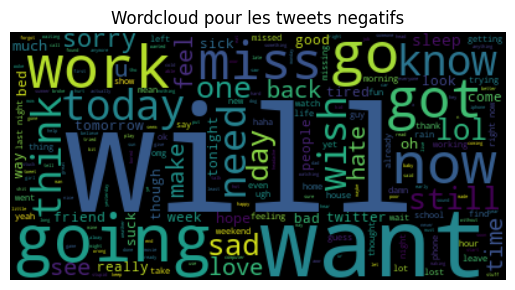

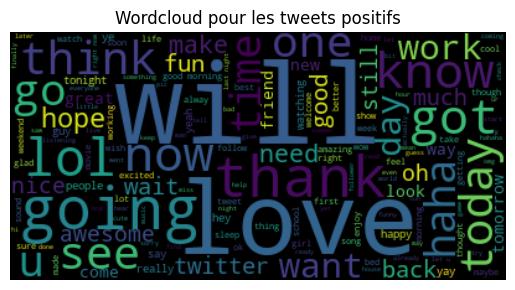

In [10]:
def generate_wordcloud(dataframe, column_name, title):
    """
    Génère un nuage de mots à partir d'une colonne d'un DataFrame.
    Args:
        dataframe (pd.DataFrame): DataFrame contenant les données.
        column_name (str): Nom de la colonne contenant le texte.
        title (str): Titre du nuage de mots.
    """
    text = " ".join(review for review in dataframe[column_name])
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

df_sample_neg = df_sample.loc[df_sample['target']==0, :]
df_sample_pos = df_sample.loc[df_sample['target']==1, :]
generate_wordcloud(df_sample_neg, 'clean_text_lem', 'Wordcloud pour les tweets negatifs')
generate_wordcloud(df_sample_pos, 'clean_text_lem', 'Wordcloud pour les tweets positifs')

In [8]:
def train_valid_test_split(X, y, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0):
    """
    Sépare les données en ensembles d'entraînement, de validation et de test.
    Args:
        X: Caractéristiques.
        y: Cibles.
        train_size (float): Proportion des données d'entraînement.
        valid_size (float): Proportion des données de validation.
        test_size (float): Proportion des données de test.
        random_state (int): Graine aléatoire pour la reproductibilité.
    Return:
        Tuple: Ensembles d'entraînement, de validation et de test.
    """
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("Les proportions ne s'additionnent pas à 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                        y,
                                                        stratify=y,
                                                        test_size=1-train_size,
                                                        random_state=random_state)

    relative_test_size = test_size / (valid_size + test_size)

    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                        stratify=y_temp,
                                                        test_size=relative_test_size,
                                                        random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [9]:
def calcul_metrics(y_valid, y_valid_pred, y_valid_proba, recover = False):
    """
    Calcule et affiche diverses métriques de classification.
    Args:
        y_valid: Vrais labels de l'ensemble de validation.
        y_valid_pred: Labels prédits pour l'ensemble de validation.
        y_valid_proba: Probabilités prédites pour la classe positive.
        recover (bool): Si vrai, renvoie les scores.
    Return:
        Tuple[float]: Scores si `recover` est vrai.
    """
    print(classification_report(y_valid, y_valid_pred))
    accuracy = accuracy_score(y_valid, y_valid_pred)
    print("Accuracy score :", accuracy)
    precision = precision_score(y_valid, y_valid_pred)
    print("Precision Score :", precision)
    recall = recall_score(y_valid, y_valid_pred)
    print("Recall Score :", recall)
    f1 = f1_score(y_valid, y_valid_pred)
    print("F1 Score :", f1)
    roc_auc = roc_auc_score(y_valid, y_valid_proba)
    print("AUC :" , roc_auc)
    aucpr_score = average_precision_score(y_valid, y_valid_proba)
    print("Average-precision score : ", aucpr_score, "\n")
    
    if recover:
        return accuracy, precision, recall, f1, roc_auc, aucpr_score

## Regression Logistique

### BoW - TFIDF

In [24]:
%%time
mlflow.set_tracking_uri('file://' + os.path.abspath('mlruns'))
experiment_name = "Regression Logistique"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="TFIDF 500K sample"):
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(stem=True, rejoin=True)),
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(**params))
    ])
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['text'] ,df_sample['target'])
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_valid, y_valid_pred, y_valid_proba, recover=True)
    mlflow.log_param("preprocessing", "Stemming et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "average_precision_score":aucpr_score,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf & stem",
        signature=signature,
        registered_model_name="tf-idf & stem",
    )

2023/07/09 21:57:50 INFO mlflow.tracking.fluent: Experiment with name 'Regression Logistique' does not exist. Creating a new experiment.
C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.80      0.78      0.79     75000
           1       0.79      0.80      0.79     75000

    accuracy                           0.79    150000
   macro avg       0.79      0.79      0.79    150000
weighted avg       0.79      0.79      0.79    150000

Accuracy score : 0.7922133333333333
Precision Score : 0.7850379773176569
Recall Score : 0.8048
F1 Score : 0.7947961655957022
AUC : 0.8717412984888889
Average-precision score :  0.8725936541059651 



C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'tf-idf & stem'.
2023/07/09 22:12:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf & stem, version 1


CPU times: total: 11min 51s
Wall time: 14min 11s


Created version '1' of model 'tf-idf & stem'.


In [25]:
%%time
with mlflow.start_run(run_name="TFIDF 500K sample"):
    pipeline.set_params(clean_text__stem=False, clean_text__lemmatize=True)
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_valid, y_valid_pred,y_valid_proba, recover=True)
    mlflow.log_param("preprocessing", "Lemmatisation et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf & lem",
        signature=signature,
        registered_model_name="tf-idf & lem",
    )

C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.80      0.78      0.79     75000
           1       0.79      0.81      0.80     75000

    accuracy                           0.80    150000
   macro avg       0.80      0.80      0.80    150000
weighted avg       0.80      0.80      0.80    150000

Accuracy score : 0.79686
Precision Score : 0.7898306408570797
Recall Score : 0.8089866666666666
F1 Score : 0.7992938960209196
AUC : 0.8764124612444444
Average-precision score :  0.8769417147693779 



Successfully registered model 'tf-idf & lem'.
2023/07/09 22:23:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf & lem, version 1


CPU times: total: 9min 29s
Wall time: 11min 4s


Created version '1' of model 'tf-idf & lem'.


In [41]:
def analyse_text_data(df, column_name):
    """
    Analyse une colonne textuelle d'un DataFrame et retourne le nombre de mots uniques, 
    ainsi que la taille de la séquence la plus longue.
    Args:
        df (pd.DataFrame): DataFrame contenant les données.
        column_name (str): Nom de la colonne à analyser.
    Return:
        Tuple[int, int, float]: Nombre de mots uniques, longueur (en tokens) de la phrase la plus longue.
    """
    df['tokens'] = df[column_name].apply(word_tokenize)
    all_text = ' '.join(df['processed_text'])
    unique_tokens = set(word_tokenize(all_text))
    num_unique_tokens = len(unique_tokens)
    max_len = df['tokens'].str.len().max()
    return num_unique_tokens, max_len

num_unique_tokens, max_len = analyse_text_data(df_sample, 'clean_text_lem')

print(f'Nombre de tokens uniques : {num_unique_tokens}')
print(f'Longueur de la séquence de mots la plus longue : {max_len}')

Nombre de tokens uniques : 250051
Longueur de la séquence de mots la plus longue : 40


## Modèle simple avec Keras

#### Préparation des données

In [11]:
nb_words = 25_000
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['clean_text_lem'] ,df_sample['target'])
tokenizer = Tokenizer(num_words=nb_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_train = pad_sequences(sequences_train, padding='post')
padded_sequences_valid = pad_sequences(sequences_valid, padding='post', maxlen=padded_sequences_train.shape[1])
padded_sequences_test = pad_sequences(sequences_test, padding='post', maxlen=padded_sequences_train.shape[1])

## Modèles Keras 

In [13]:
def create_embedding(model):
    """
    Crée une matrice d'incorporation (embedding) à partir d'un modèle glove.
    Args:
        model: Modèle Glove le vocabulaire et les vecteurs.
    Return:
        Tuple[int, int, np.array]: Taille du vocabulaire, dimension des vecteurs d'incorporation, matrice d'incorporation.
    """
    vocab_size = len(model.vocab) + 1
    embedding_dim = model.vector_size  

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for i, word in enumerate(model.index2word):
        embedding_matrix[i] = model[word]
        
    return vocab_size, embedding_dim, embedding_matrix

In [10]:
def plot_hist(hist, model_name):
    """
    Trace et sauvegarde les courbes d'exactitude et de perte en fonction des époques pour l'entraînement et la validation.
    Args:
        hist: Historique retourné par la méthode fit() de Keras.
        model_name (str): Nom du modèle pour lequel le graphique est tracé.
    """
    sns.set()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, ':', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.savefig(f'{model_name}_training_accuracy_loss.png')
    plt.show()

### Keras simple avec Glove

#### Glove

In [14]:
glove_model = api.load("glove-twitter-50")
vocab_size, embedding_dim, embedding_matrix = create_embedding(glove_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            59675750  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 128)           32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
____

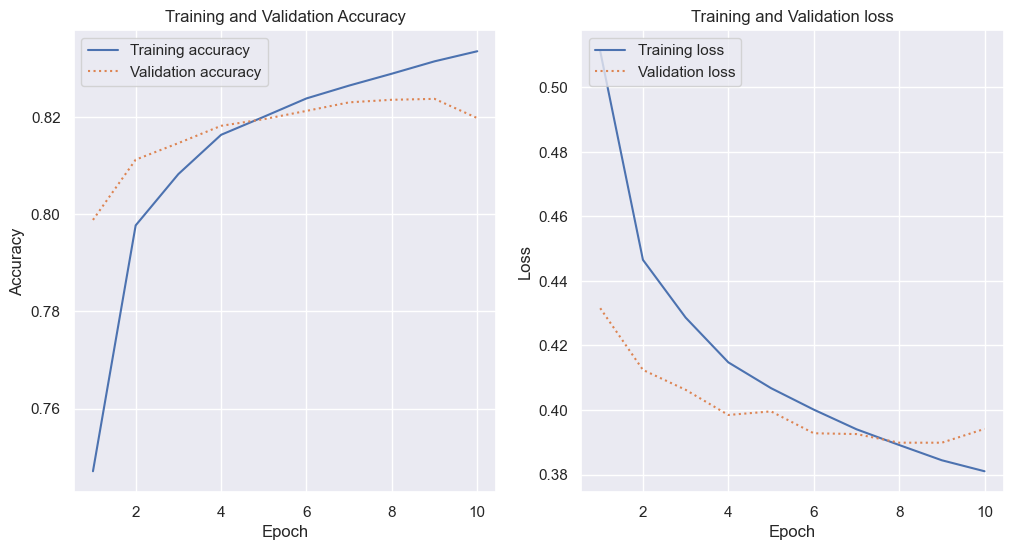

Registered model 'Keras Glove' already exists. Creating a new version of this model...
2023/08/10 13:49:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Keras Glove, version 8


CPU times: total: 4min 1s
Wall time: 18min 4s


Created version '8' of model 'Keras Glove'.


In [15]:
%%time
experiment_name = "Keras simple"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras Glove"):
    
    batch_size = 256
    dropout_rate = 0.3
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=padded_sequences_train.shape[1],
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Conv1D(128, 5, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_acc', patience=1)

    hist = model.fit(
        padded_sequences_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(padded_sequences_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )
    
    y_pred_prob = model.predict(padded_sequences_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
    scores = model.evaluate(padded_sequences_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    mlflow.log_params({
    "batch_size": batch_size,
    "embedding_dim": embedding_dim,
    "vocab_size": vocab_size,
    "input_length": padded_sequences_train.shape[1],
    "SpatialDropout1D_rate": dropout_rate,
    "Conv1D_filters": 128,
    "Conv1D_kernel_size": 5,
    "MaxPooling1D_pool_size": 4,
    "Dense_units": 16,
    "Dropout_rate": dropout_rate,
    "loss_function": 'binary_crossentropy',
    "optimizer": 'adam',
    "epochs": 10,
    "early_stopping_monitor": 'val_acc',
    "early_stopping_patience": 1
    })
    
    signature = infer_signature(padded_sequences_test, y_pred_prob)
    model_name = "Keras_simple_Glove"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
    model,
    signature=signature,
    artifact_path="Keras Glove",
    registered_model_name="Keras Glove",
)

### LSTM - Glove

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            59675750  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 128)           32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
____

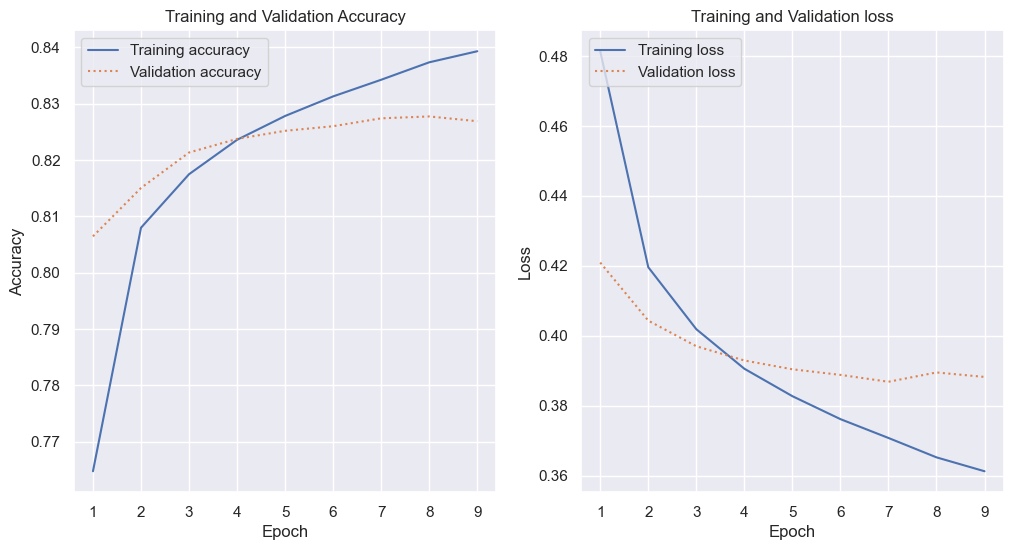

Registered model 'LSTM-Glove' already exists. Creating a new version of this model...
2023/08/10 16:43:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM-Glove, version 3


CPU times: total: 3min 26s
Wall time: 20min 24s


Created version '3' of model 'LSTM-Glove'.


In [15]:
%%time
experiment_name = "Keras LSTM"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="LSTM-Glove"):
    
    batch_size = 256
    lstm_out = 128
    dropout_rate = 0.3
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=padded_sequences_train.shape[1],
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Conv1D(128, 5, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(lstm_out))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_acc', patience=1)
    
    hist = model.fit(
        padded_sequences_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(padded_sequences_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    y_pred_prob = model.predict(padded_sequences_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
   
    scores = model.evaluate(padded_sequences_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    mlflow.log_params({
        "batch_size": batch_size,
        "embedding_dim": embedding_dim,
        "vocab_size": vocab_size,
        "input_length": padded_sequences_train.shape[1],
        "SpatialDropout1D_rate": dropout_rate,
        "Conv1D_filters": 128,
        "Conv1D_kernel_size": 5,
        "MaxPooling1D_pool_size": 4,
        "lstm_units": lstm_out,
        "Dropout_rate": dropout_rate,
        "Dense_units": 16,
        "loss_function": 'binary_crossentropy',
        "optimizer": 'adam',
        "epochs": 10,
        "early_stopping_monitor": 'val_acc',
        "early_stopping_patience": 1
    })
    signature = infer_signature(padded_sequences_test, y_pred_prob)
    model_name = "LSTM-Glove"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    
    mlflow.keras.log_model(
    model,
    signature = signature,
    artifact_path="LSTM-Glove",
    registered_model_name="LSTM-Glove",
)

### Keras simple avec Fasttext

#### Fasttext

In [17]:
fasttext.util.download_model('en', if_exists='ignore')  
ft_model = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(ft_model, 50)
print(ft_model.get_dimension())

50


In [18]:
def create_embedding_matrix(ft_model):
    """
    Crée une matrice d'incorporation (embedding) à partir d'un modèle FastText.
    Args:
        ft_model: Modèle FastText.
    Retour:
        Tuple[int, int, np.array]: Taille du vocabulaire, dimension des vecteurs d'incorporation, matrice d'incorporation.
    """
    vocab_size = len(ft_model.get_words())  
    embedding_dim = ft_model.get_dimension()  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for i, word in enumerate(ft_model.get_words()):
        embedding_matrix[i] = ft_model.get_word_vector(word)

    return vocab_size, embedding_dim, embedding_matrix
vocab_size, embedding_dim, embedding_matrix = create_embedding_matrix(ft_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            100000000 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 128)           32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

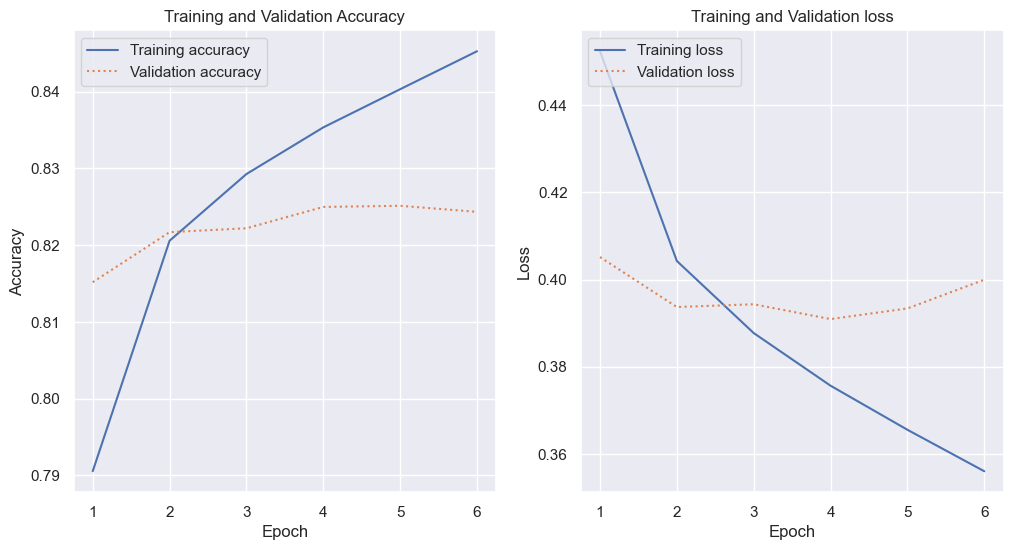

Registered model 'Keras Fasttext' already exists. Creating a new version of this model...
2023/08/10 14:07:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Keras Fasttext, version 7


CPU times: total: 6min 26s
Wall time: 17min 3s


Created version '7' of model 'Keras Fasttext'.


In [19]:
%%time
experiment_name = "Keras simple"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras Fasttext"):
    
    batch_size = 256
    dropout_rate = 0.3
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=padded_sequences_train.shape[1],
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Conv1D(128, 5, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_acc', patience=1)
    
    hist = model.fit(
        padded_sequences_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(padded_sequences_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )
    
    y_pred_prob = model.predict(padded_sequences_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
   
    scores = model.evaluate(padded_sequences_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    mlflow.log_params({
        "batch_size": batch_size,
        "embedding_dim": embedding_dim,
        "vocab_size": vocab_size,
        "input_length": padded_sequences_train.shape[1],
        "SpatialDropout1D_rate": dropout_rate,
        "Conv1D_filters": 128,
        "Conv1D_kernel_size": 5,
        "MaxPooling1D_pool_size": 4,
        "Dense_units": 16,
        "Dropout_rate": dropout_rate,
        "loss_function": 'binary_crossentropy',
        "optimizer": 'adam',
        "epochs": 10,
        "early_stopping_monitor": 'val_acc',
        "early_stopping_patience": 1
    })
    signature = infer_signature(padded_sequences_test, y_pred_prob)
    model_name = "Keras_simple_Fasttext"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
    model,
    signature = signature,
    artifact_path="Keras Fasttext",
    registered_model_name="Keras Fasttext",
)

## Modèle Keras avec Embedding pré entrainé Fasttext + couche LSTM (model déployé)

### Entrainement du modèle 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 50)            100000000 
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 128)           32128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

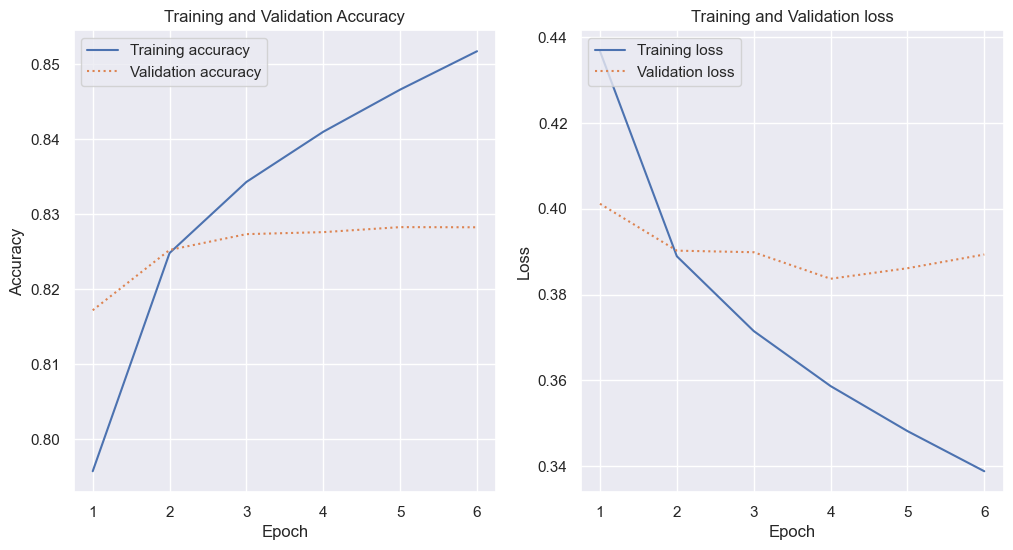

Registered model 'LSTM-Fasttext' already exists. Creating a new version of this model...
2023/08/10 17:04:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM-Fasttext, version 11


CPU times: total: 6min 23s
Wall time: 19min 36s


Created version '11' of model 'LSTM-Fasttext'.


In [19]:
%%time
experiment_name = "Keras LSTM"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="LSTM-Fasttext"):
    
    batch_size = 256
    lstm_out = 128
    dropout_rate = 0.3
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=padded_sequences_train.shape[1],
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Conv1D(128, 5, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(lstm_out))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_acc', patience=1)
    
    hist = model.fit(
        padded_sequences_train, 
        y_train, 
        epochs=10, 
        batch_size=batch_size, 
        validation_data=(padded_sequences_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    y_pred_prob = model.predict(padded_sequences_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
   
    scores = model.evaluate(padded_sequences_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    mlflow.log_params({
        "batch_size": batch_size,
        "embedding_dim": embedding_dim,
        "vocab_size": vocab_size,
        "input_length": padded_sequences_train.shape[1],
        "SpatialDropout1D_rate": dropout_rate,
        "Conv1D_filters": 128,
        "Conv1D_kernel_size": 5,
        "MaxPooling1D_pool_size": 4,
        "lstm_units": lstm_out,
        "Dropout_rate": dropout_rate,
        "Dense_units": 16,
        "loss_function": 'binary_crossentropy',
        "optimizer": 'adam',
        "epochs": 10,
        "early_stopping_monitor": 'val_acc',
        "early_stopping_patience": 1
    })
    signature = infer_signature(padded_sequences_test, y_pred_prob)
    model_name = "LSTM-Fasttext"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    
    mlflow.keras.log_model(
    model,
    signature = signature,
    artifact_path="LSTM-Fasttext",
    registered_model_name="LSTM-Fasttext",
)

#### Sauvegarde du modèle et du Tokenizer

In [24]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)
model.save('saved_model/lstm')

### Conversion du modèle en modèle tflite

In [ ]:
import tensorflow as tf
lstm_model = tf.keras.models.load_model('saved_model/lstm')

# Convertir le modèle LSTM en modèle TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Sauvegarder le modèle TFLite dans un fichier
with open('lstm_classification.tflite', 'wb') as f:
    f.write(tflite_model)

### Explication locale et globale du modèle

In [15]:
with open('tokenizer.json', 'r', encoding='utf-8') as f:
    loaded_tokenizer_json = f.read()
tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(loaded_tokenizer_json)
model = load_model('saved_model/lstm')

In [21]:
text_neg = df_sample.loc[df_sample['target'] == 0, :]
text_pos = df_sample.loc[df_sample['target'] == 1, :]
sample_text_neg = text_neg.sample(100, random_state=0)
sample_text_pos = text_pos.sample(100, random_state=0)
print(sample_text_neg.iloc[0][1])
print(sample_text_pos.iloc[0][1])

@DreaRamirez No...I'm sooo tired!   But I got to see all them at dinner. We all got to wait on them. It was crazy for us!
@silkehartung Technically, isn't the MC a performer too?!


In [22]:
clean_text_neg = clean_docs(sample_text_neg['text'], lemmatize=True, rejoin=True)
clean_text_pos = clean_docs(sample_text_pos['text'], lemmatize=True, rejoin=True)

### LIME

In [23]:
def tokenized_predict(texts):
    """
    Prédit les labels pour une liste de textes après tokenisation et padding.
    Args:
        texts (List[str]): Liste de textes à prédire.
    Return:
        np.array: Probabilités prédites.
    """
    seq = tokenizer.texts_to_sequences(texts)
    padded_seq = pad_sequences(seq, maxlen=40)
    predictions = model.predict(padded_seq)
    return np.hstack((1 - predictions, predictions))

# Create a LIME Text Explainer
explainer = LimeTextExplainer(class_names=["Negative", "Positive"])
exp = explainer.explain_instance(clean_text_neg[0], tokenized_predict, num_features=6)
exp.show_in_notebook(text=True)

In [24]:
exp = explainer.explain_instance(clean_text_pos[3], tokenized_predict, num_features=6)
exp.show_in_notebook(text=True)
plt.savefig("lime_tweet1.png")

<Figure size 640x480 with 0 Axes>

In [30]:
exp = explainer.explain_instance(clean_text_pos[2], tokenized_predict, num_features=5)
exp.show_in_notebook(text=True)
plt.savefig("lime_tweet2.png")

<Figure size 640x480 with 0 Axes>

Le principal inconvénient de l'utilisation de LIME à des fins de NLP est qu'il s'est avéré instable, ce qui signifie qu'un échantillonnage différent autour des mêmes données locales peut conduire à des résultats d'explication très différents (Molnar, 2019).

### SHAP

In [25]:
def f(texts):
    """
    Transforme une liste de textes en séquences tokenisées et padded, puis prédit les labels.
    Args:
        texts (List[str]): Liste de textes à prédire.
    Return:
        np.array: Probabilités prédites.
    """
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=model.input_shape[1])
    probs = model.predict(padded_sequences)
    return np.hstack([1 - probs, probs])

In [13]:
df_sample = create_sample(df, 25_000)
df_sample['clean_text_lem'] = tqdm(clean_docs(df_sample['text'], lemmatize=True, rejoin=True))

100%|███████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 3845163.18it/s]


In [33]:
X_test.shape

(5000,)

In [127]:
y_train[:1000].value_counts()

0    540
1    460
Name: target, dtype: int64

In [16]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['clean_text_lem'] ,df_sample['target'])
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_train = pad_sequences(sequences_train, padding='post', maxlen=model.input_shape[1])
padded_sequences_valid = pad_sequences(sequences_valid, padding='post', maxlen=model.input_shape[1])
padded_sequences_test = pad_sequences(sequences_test, padding='post', maxlen=model.input_shape[1])

In [30]:
shap.initjs()
background = padded_sequences_train[:1000]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(padded_sequences_test[:200]) 
num2word = {i: word for word, i in tokenizer.word_index.items()}
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), padded_sequences_test[i]))) for i in range(200)])

### Explicabilité locale

In [34]:
print(X_test.iloc[1])
print(y_test.iloc[1])
shap.force_plot(explainer.expected_value[0], shap_values[0][1], x_test_words[1])

happy birthday to my sisterrrrrrrrrrrrrr chocolate cake all round and hugeeeee fondant fancy cake happy birthday for the other day tashh
1


In [36]:
print(X_test.iloc[3])
print(y_test.iloc[3])
shap.force_plot(explainer.expected_value[0], shap_values[0][3], x_test_words[3])

wow i need a job
0


### Explicabilité globale

In [37]:
y_test.iloc[:500].value_counts()

1    261
0    239
Name: target, dtype: int64

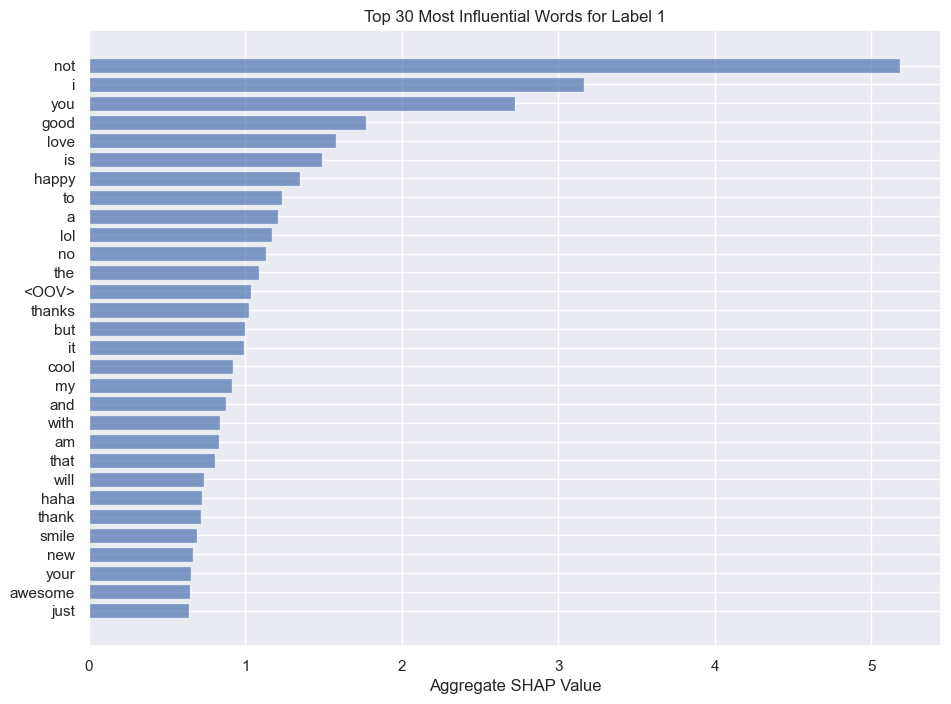

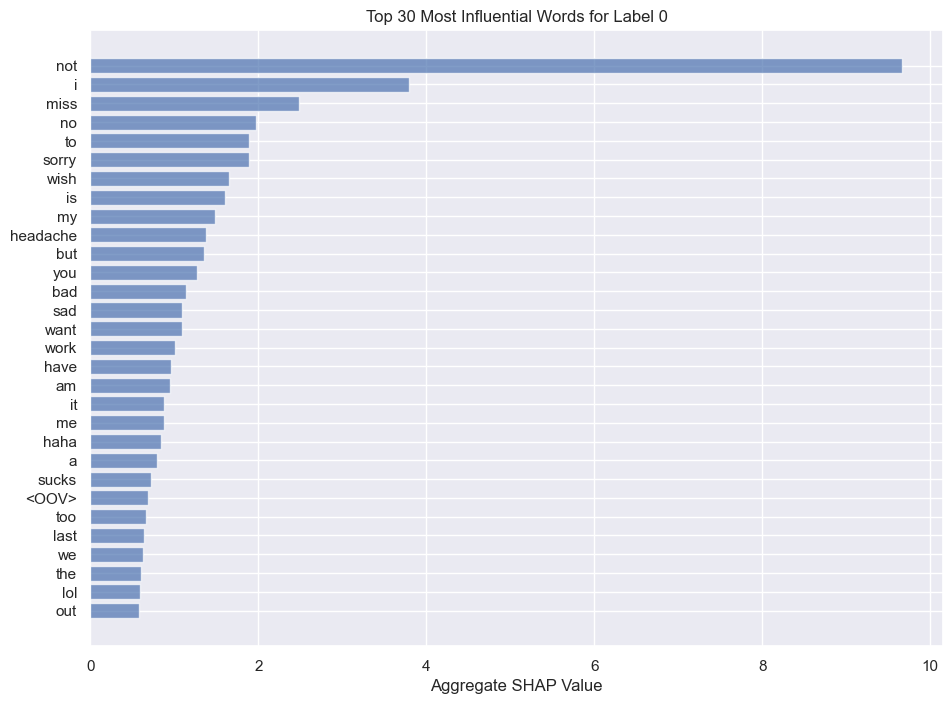

In [38]:
def plot_most_influential_words(y_subset, padded_sequences, model, background, tokenizer, label, N=30):
    """
    Affiche un diagramme à barres horizontales des N mots les plus influents pour un label spécifié, en utilisant les valeurs SHAP.

    Args:
    - y_subset (numpy.array ou pandas.Series): Sous-ensemble des labels cibles à considérer.
    - padded_sequences (numpy.array): Séquences tokenisées et complétées correspondant à `y_subset`.
    - model (tensorflow.keras.Model): Modèle formé pour lequel les mots influents doivent être déterminés.
    - background (numpy.array): Données utilisées comme référence pour calculer les valeurs SHAP.
    - tokenizer (keras_preprocessing.text.Tokenizer): Tokenizer utilisé pour convertir les mots en leurs indices correspondants.
    - label (int): Label cible pour lequel les mots influents doivent être déterminés.
    - N (int, optionnel): Nombre de mots influents à afficher. Par défaut, 30.

    Return:
    Affiche un diagramme à barres des N mots influents et de leurs valeurs SHAP agrégées.

    Remarques:
    - Les valeurs SHAP (SHapley Additive exPlanations) indiquent l'impact de chaque mot sur la sortie du modèle.
    - Cette fonction calcule en interne les valeurs SHAP pour le label spécifié en utilisant le DeepExplainer.

    """
    indices = np.where(y_subset == label)[0]
    padded_sequences_label = padded_sequences[indices]
    explainer = shap.DeepExplainer(model, background)
    shap_values_samples = explainer.shap_values(padded_sequences_label)
    num2word = {i: word for word, i in tokenizer.word_index.items()}
    x_test_words_label = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), padded_sequences_label[i]))) for i in range(len(indices))])
    
    word_shap_values = defaultdict(float)
    for sample_words, sample_shap_values in zip(x_test_words_label, shap_values_samples[0]):
        for word, shap_value in zip(sample_words, sample_shap_values):
            if word != "NONE":
                word_shap_values[word] += np.abs(shap_value)
    sorted_words = sorted(word_shap_values.keys(), key=lambda x: word_shap_values[x], reverse=True)
    top_words = sorted_words[:N]
    top_shap_values = [word_shap_values[word] for word in top_words]
    
    plt.figure(figsize=(11, 8))
    y_pos = range(len(top_words))
    plt.barh(y_pos, top_shap_values, align='center', alpha=0.7)
    plt.yticks(y_pos, top_words)
    plt.xlabel('Aggregate SHAP Value')
    plt.title('Top {} Most Influential Words for Label {}'.format(N, label))
    plt.gca().invert_yaxis()  
    plt.show()


y_test_subset = y_test.iloc[:500]
plot_most_influential_words(y_test_subset, padded_sequences_test, model, background, tokenizer, 1, N=30)

plot_most_influential_words(y_test_subset, padded_sequences_test, model, background, tokenizer, 0, N=30)

## BERT - Bidirectional Encoder Representations from Transformers

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_base = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
ADD_DENSE = True
DENSE_DIM = 16
ADD_DROPOUT = True
DROPOUT = 0.2
learning_rate = 1e-5

def bert_encode(data, maximum_len, batch_size):
    """
    Encode une liste de textes pour BERT.
    Args:
        data (List[str]): Liste de textes.
        maximum_len (int): Longueur maximale des séquences.
        batch_size (int): Taille de lot pour l'encodage. 
    Return:
        Tuple[np.array, np.array]: IDs des tokens et masques d'attention.
    """
    input_ids = []
    attention_masks = []

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        for text in batch:
            encoded = tokenizer.encode_plus(text,
                                            add_special_tokens=True,
                                            padding='max_length',
                                            max_length=maximum_len,
                                            return_attention_mask=True,
                                            truncation=True)
        
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

def build_bert_model(model_layer, learning_rate, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    """
    Construit un modèle basé sur BERT avec des couches supplémentaires optionnelles.
    Args:
        model_layer: Couche BERT pré-formée.
        learning_rate (float): Taux d'apprentissage.
        add_dense (bool, optionnel): Si vrai, ajoute une couche dense. Par défaut à True.
        dense_dim (int, optionnel): Dimension de la couche dense. Nécessaire si add_dense est True.
        add_dropout (bool, optionnel): Si vrai, ajoute une couche de dropout. Par défaut à True.
        dropout (float, optionnel): Taux de dropout. Nécessaire si add_dropout est True.
        
    Return:
        Model: Modèle construit avec Keras.
    """
    input_ids = Input(shape=(40,),dtype='int32')
    attention_masks = Input(shape=(40,),dtype='int32')
    transformer_layer = model_layer([input_ids,attention_masks])
    output = transformer_layer[1]
    
    if add_dense:
        print("Training with additional dense layer...")
        output = Dense(dense_dim,activation='relu')(output)
    
    if add_dropout:
        print("Training with dropout...")
        output = Dropout(dropout)(output)
    
    output = Dense(1,activation='sigmoid')(output)
    model = Model(inputs=[input_ids,attention_masks], outputs=output)
    model.compile(Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

BERT_base = build_bert_model(bert_base, learning_rate = learning_rate)
BERT_base.summary()

Training with additional dense layer...
Training with dropout...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                             

In [10]:
def plot_hist_bis(hist, model_name):
    sns.set()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, ':', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.savefig(f'{model_name}_training_accuracy_loss.png')
    plt.show()

Encoding Tweets...
Tweets encoded
Epoch 1/3
18750/18750 [==============================] - 4262s 227ms/step - loss: 0.3603 - accuracy: 0.8428 - val_loss: 0.3352 - val_accuracy: 0.8547
Epoch 2/3
18750/18750 [==============================] - 4280s 228ms/step - loss: 0.3124 - accuracy: 0.8670 - val_loss: 0.3259 - val_accuracy: 0.8598
Epoch 3/3
18750/18750 [==============================] - 4280s 228ms/step - loss: 0.2774 - accuracy: 0.8840 - val_loss: 0.3362 - val_accuracy: 0.8601
Test accuracy with BERT: 86.00%
4688/4688 [==============================] - 240s 51ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     75000
           1       0.87      0.84      0.86     75000

    accuracy                           0.86    150000
   macro avg       0.86      0.86      0.86    150000
weighted avg       0.86      0.86      0.86    150000

Accuracy score : 0.85998
Precision Score : 0.8717009706064569
Recall Score : 0.8442133333333334
F

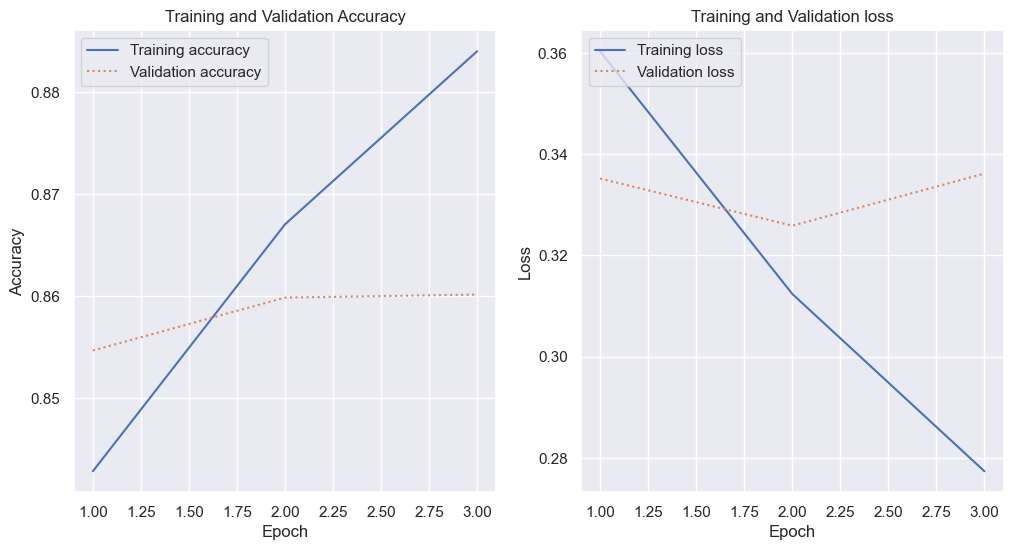

INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpzlnrs76n\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpzlnrs76n\model\data\model\assets
2023/08/24 07:37:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\aurel\AppData\Local\Temp\tmpzlnrs76n\model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.
Registered model 'BERT-Base-Uncased' already exists. Creating a new version of this model...
2023/08/24 07:37:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: BERT-Base-Uncased, version 3
Created version '3' of model 'BERT-Base-Uncased'.


In [13]:
experiment_name = "BERT"
mlflow.set_experiment(experiment_name)


with mlflow.start_run(run_name="BERT-Base-Uncased"):
    max_len = 40
    batch_size = 64

    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True, rejoin=True)),
    ])
    
    X = pipeline.transform(df_sample['text'])  
    y = df_sample['target'].values
    
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y)
    
    print('Encoding Tweets...')
    train_input_ids,train_attention_masks = bert_encode(X_train, max_len, 50_000)
    valid_input_ids,valid_attention_masks = bert_encode(X_valid, max_len, 50_000)
    test_input_ids,test_attention_masks = bert_encode(X_test, max_len, 50_000)
    print('Tweets encoded')

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)

    hist = BERT_base.fit(
        [train_input_ids,train_attention_masks], 
        y_train, 
        validation_data=([valid_input_ids,valid_attention_masks], y_valid), 
        epochs=3,
        callbacks=[early_stopping],
        verbose=1,
        batch_size=batch_size
    )

    scores = BERT_base.evaluate([test_input_ids, test_attention_masks], y_test, verbose=0)
    print("Test accuracy with BERT: %.2f%%" % (scores[1]*100))

    y_pred_prob = BERT_base.predict([test_input_ids, test_attention_masks])
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    input_samples = {"input_ids": test_input_ids, "attention_mask": test_attention_masks}
    output_samples = y_pred_prob
    signature = infer_signature(input_samples, output_samples)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })

    mlflow.log_params({
    "tokenizer_description": "Transformation of raw text into input_ids and attention_masks using BERT tokenizer.", 
    "tokenizer_name": tokenizer.name_or_path,
    "max_length": max_len,
    "truncation": "True",
    "padding": "max_length",
    "add_special_tokens": True,
    "return_attention_mask": True,
    "dense_dim": DENSE_DIM,
    "dropout": DROPOUT,
    "batch_size": batch_size,
    "optimizer": 'adam',
    "learning_rate": learning_rate,
    "epochs": 3,
    "early_stopping_monitor": 'val_accuracy',  
    "early_stopping_patience": 1
})
    
    model_name = "BERT"
    plot_hist_bis(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
        BERT_base,
        signature=signature,
        artifact_path="BERT-Base-Uncased",
        registered_model_name="BERT-Base-Uncased"
    )

## USE - Universel Sentence Encoder

In [11]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
18750/18750 [==============================] - 2063s 110ms/step - loss: 0.3982 - accuracy: 0.8211 - val_loss: 0.3795 - val_accuracy: 0.8312
Epoch 2/5
4688/4688 [===

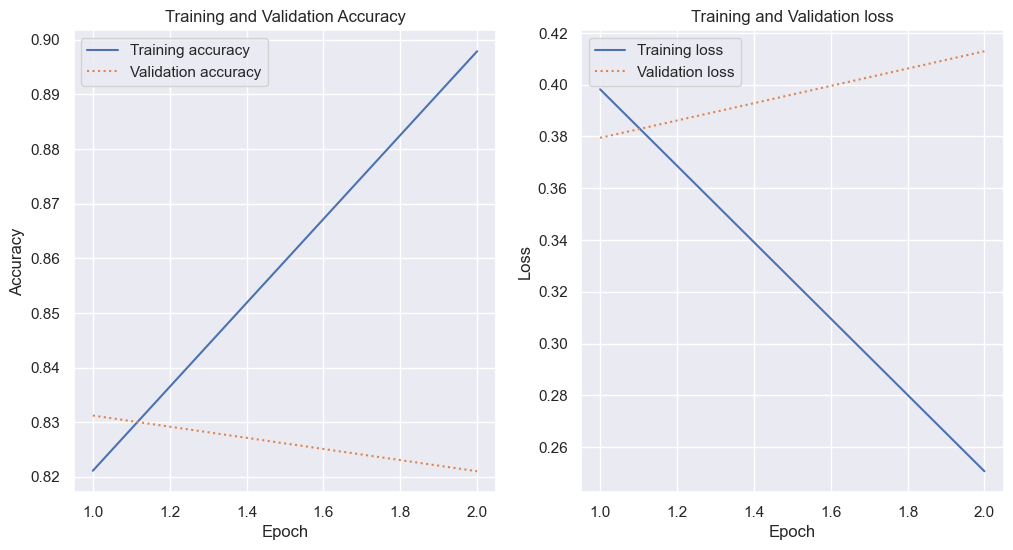

INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpcj8_s6ys\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpcj8_s6ys\model\data\model\assets
Registered model 'USE-Base' already exists. Creating a new version of this model...
2023/08/24 14:40:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: USE-Base, version 2
Created version '2' of model 'USE-Base'.


CPU times: total: 36min 37s
Wall time: 1h 22min 53s


In [12]:
%%time
experiment_name = "USE"
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="USE-Base"):
    batch_size = 64
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True, rejoin=True)),
    ])
    
    X = pipeline.transform(df_sample['text'])
    X = np.array(X)
    y = df_sample['target'].values
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y)

    
    model = Sequential()
    model.add(hub_layer)
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)
    

    hist = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=5,
        callbacks=[early_stopping],
        verbose=1, 
        batch_size=batch_size
    )

    y_pred_prob = model.predict(X_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    signature = infer_signature(X_test, y_pred_prob)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    mlflow.log_params({
    "embedding": "https://tfhub.dev/google/universal-sentence-encoder/4",
    "trainable_embedding": True,
    "dense_units": 16,
    "dense_activation": 'relu',
    "dropout": 0.2,
    "optimizer": 'adam',
    "loss": 'binary_crossentropy',
    "batch_size": batch_size,
    "epochs": 5,
    "early_stopping_monitor": 'val_accuracy',  
    "early_stopping_patience": 1
    })

    model_name = "USE"
    plot_hist_bis(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
        model,
        signature=signature,
        artifact_path="USE-Base",
        registered_model_name="USE-Base"
    )